In [25]:
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.utils as ku 
import numpy as np 
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
def read_txt(path):
    #file_path = "/content/drive/My Drive/Colab Notebooks/corpus.txt"
    with open (path, "r") as file:
         content = file.readlines()
         content = "".join(content)
    return content

In [0]:
#Question 1: Data Preprocessing

def data_preprocessing(token):
    n = len(token)
    for i in range(n):
        #Converting all sentences into lower case
        token[i] = token[i].lower()
        #Removing all special charachters from the sentences
        temp = token[i]
        token[i] = ""
        for k in temp:
            token[i] += re.sub(r"[^a-zA-Z0-9]+", ' ', k)
        #Removing all numbers from the sentence
        token[i] = re.sub(r'\d+', '', token[i])
        #Eliminating extra spaces from tokens
        token[i] = re.sub(' +', ' ',token[i])
    return token   

In [0]:
#Question 2: Tokenization

def tokenize(content):
    #Replacing Enter by Space
    content = content.replace("\n", " ")
    #Implement Sentence Tokenization
    sent_token = sent_tokenize(content)
    return sent_token



In [0]:
#Creating input sequences from tokens

def input_creation(content):
    tokenizer = Tokenizer()
    corpus = tokenize(content)
    corpus = data_preprocessing(corpus)
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    #Creating input sequences using list of tokens
    input_sequences = []
    for line in corpus:
	      token_list = tokenizer.texts_to_sequences([line])[0]
	      for i in range(1, len(token_list)):
		        n_gram_sequence = token_list[:i+1]
		        input_sequences.append(n_gram_sequence)
    #Padding sequences generated
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')) 
    return max_sequence_len, input_sequences, tokenizer, total_words

In [0]:
#Creating predictor and labels

def predictor_label_creation(input_sequences):
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label    

In [0]:
#Building the Deep Recurrent Neural Network

def model_build(total_words):
    model = Sequential()                                                         #Initialization of Sequential Model
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))      #Embedding layer with input dimension as no. of word and setting Embedding dimension as 100
    model.add(Bidirectional(LSTM(150, return_sequences = True)))                 #Bidirectional LSTM containing 150 units with enabled return sequences
    model.add(Dropout(0.2))                                                      #Dropout Rate set to 20% to reduce overfitting
    model.add(LSTM(100))                                                         #Unidirectional LSTM with 100 units
    model.add(Dense(total_words/2, activation='relu'))                           #Dense Hidden layer 
    model.add(Dense(total_words, activation='softmax'))                          #Dense Output layer 
    print(model.summary())                                                       #Glancing through the Model Built
    return model

In [0]:
#Model Compilation and Optimization

def model_optimize(model):
    Optimizer = Adam(learning_rate=0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = Optimizer , metrics=['accuracy'])
    return model

In [0]:
#Question 3: Model Training

def model_train(model):
    history = model.fit(predictors, label, epochs=150, batch_size=50, verbose=1)
    return model, history

In [0]:
#Predicting the sentence based on input sentence

def predict(max_sequence_len, tokenizer):
    seed_text = input("Enter an incomplete sentence\n")
    #Predicting the next part of the sentence based on built model
    try:
        next_words = int(input("Enter the no. of word to be predicted\n"))
   
        for _ in range(next_words):
	          token_list = tokenizer.texts_to_sequences([seed_text])[0]
	          token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	          predicted = model.predict_classes(token_list, verbose=0)
	          output_word = ""
	          for word, index in tokenizer.word_index.items():
		            if index == predicted:
			             output_word = word
			             break
	          seed_text += " " + output_word
        print("\n")    
        print("The predicted sentence is:\n")
        print(seed_text)
    #Exception handling in case the no. of words to be predicted is null
    except:
        print("The Entered value must be an integer!!!")

In [35]:
#File Selection, Tokenization and Data Preprocessing

file_name = input("Enter the Text File name\n")
file_path = "/content/drive/My Drive/Colab Notebooks/" + str(file_name)
file_content = read_txt(file_path)
#Displaying Data after being pre-processed and Tokenized
token = tokenize(file_content)
token = data_preprocessing(token)
print("The text file after Sentence Tokenization and Data Preprocessing is:\n")
print(token)
print("\n")

Enter the Text File name
corpus.txt
The text file after Sentence Tokenization and Data Preprocessing is:

['one winter s evening towards the close of the year or within a year or two of that time a young medical practitioner recently established in business was seated by a cheerful fire in his little parlour listening to the wind which was beating the rain in pattering drops against the window or rumbling dismally in the chimney ', 'the night was wet and cold he had been walking through mud and water the whole day and was now comfortably reposing in his dressing gown and slippers more than half asleep and less than half awake revolving a thousand matters in his wandering imagination ', 'first he thought how hard the wind was blowing and how the cold sharp rain would be at that moment beating in his face if he were not comfortably housed at home ', 'then his mind reverted to his annual christmas visit to his native place and dearest friends he thought how glad they would all be to see h

In [36]:
#Creation of input, predictors, labels. Model building and training

max_sequence_len, input_sequences, tokenizer, total_words = input_creation(file_content)
predictors, label = predictor_label_creation(input_sequences)
model = model_build(total_words)
model = model_optimize(model)
model, history = model_train(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 102, 100)          133300    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 102, 300)          301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 102, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 666)               67266     
_________________________________________________________________
dense_3 (Dense)              (None, 1333)              889111    
Total params: 1,551,277
Trainable params: 1,551,277
Non-trainable params: 0
____________________________________________

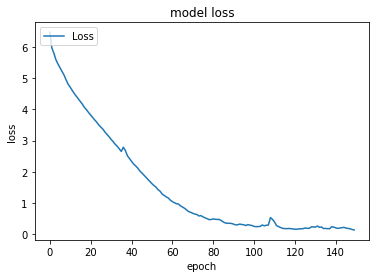

In [37]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

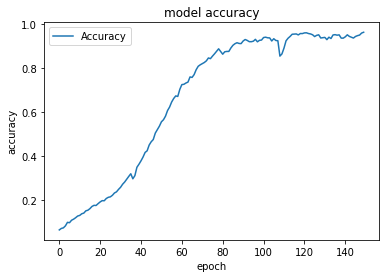

In [38]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy'], loc='upper left')
plt.show()

In [41]:
#Predicting next part of sentence based on input phrase

predict(max_sequence_len, tokenizer)

Enter an incomplete sentence
Such an awesome day
Enter the no. of word to be predicted
7


The predicted sentence is:

Such an awesome day from the surgeon preserving his searching glance


In [42]:
from keras.models import model_from_yaml
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
model.load_weights("model.h5")
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [43]:
import tensorflow as tf
model_yaml = tf.keras.models.load_model('/content/model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model_yaml)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

6300416